In [1]:
import os 
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from pandas_profiling import ProfileReport

In [2]:
tqdm.pandas()


historique météo France : 
https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm  
Calendrier scolaire : 
https://data.education.gouv.fr/explore/dataset/fr-en-calendrier-scolaire  
Jours fériés : 
https://api.gouv.fr/les-api/jours-feries  
elevation data : https://geoservices.ign.fr/documentation/services/api-et-services-ogc/calcul-altimetrique-rest


# Dirty Data import

In [60]:
data_directory = os.path.abspath('../data')

In [61]:
rename_cols = {'Nom du compteur': 'sensor_name',
               'Comptage horaire': 'count',
               'Date et heure de comptage': 'count_time',
               'mois_annee_comptage': 'count_month_year',
               'Identifiant du compteur': 'sensor_id',
               'Identifiant du site de comptage': 'position_id',
                'Nom du site de comptage': 'position_name',
                "Date d'installation du site de comptage": 'installation_date',
                'Coordonnées géographiques': 'gps_coordinates',
                'Identifiant technique compteur': 'tech_id'}

In [61]:
pdf_sensors = pd.read_csv(os.path.join(data_directory, 'comptage-velo-donnees-compteurs.csv'),
                          sep=';',
                          usecols=rename_cols.keys())

In [33]:
pdf_sensors = pdf_sensors.rename(columns=rename_cols)
pdf_sensors.loc[:, 'count_time'] = pdf_sensors['count_time'].progress_apply(
    lambda x: pd.to_datetime(x[:-6]))

100%|██████████████████████████████████████| 1018756/1018756 [01:17<00:00, 13093.41it/s]


In [203]:
pdf_sensors.iloc[:3]

sensor_name  count                 count_time  \
0  97 avenue Denfert Rochereau SO-NE  129.0  2021-07-21T18:00:00+02:00   
1  97 avenue Denfert Rochereau SO-NE   32.0  2021-07-21T15:00:00+02:00   
2  97 avenue Denfert Rochereau SO-NE   65.0  2021-07-21T17:00:00+02:00   

  count_month_year datetime_count_time  
0          2021-07 2021-07-21 18:00:00  
1          2021-07 2021-07-21 15:00:00  
2          2021-07 2021-07-21 17:00:00

# Data cleaning

In [34]:
profile = ProfileReport(pdf_sensors.astype({'position_id': str}))

In [35]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Missing values

<AxesSubplot:>

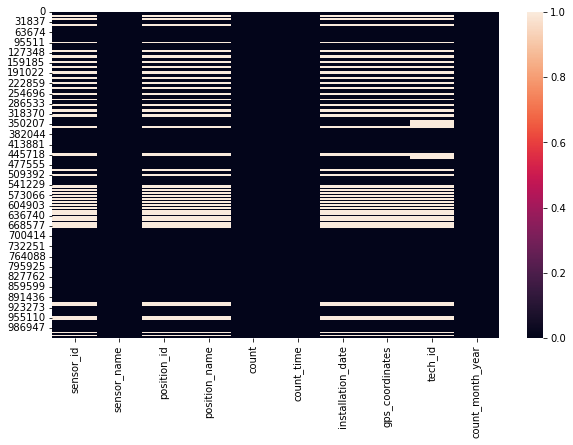

In [73]:
plt.figure(figsize=(10,6))
sns.heatmap(pdf_sensors.isnull())

sensor_id            0.720276
sensor_name          1.000000
position_id          0.720276
position_name        0.720276
count                1.000000
count_time           1.000000
installation_date    0.720276
gps_coordinates      0.720276
tech_id              0.694325
count_month_year     1.000000
dtype: float64


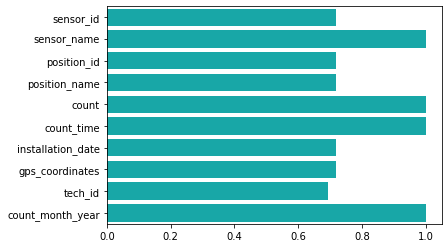

In [74]:
count_pdf = pdf_sensors.count() / pdf_sensors.shape[0]
sns.barplot(x=count_pdf, y=count_pdf.index, color='c')
print(count_pdf)

In [116]:
missing_values_cols = ['sensor_id',
                       'position_id', 
                       'position_name', 
                       'installation_date',
                       'gps_coordinates',
                       'tech_id']

In [51]:
pdf_sensors[pdf_sensors['sensor_id'].isnull()]

sensor_id              sensor_name position_id position_name  count  \
8960          NaN   105 rue La Fayette E-O         nan           NaN  584.0   
8963          NaN   105 rue La Fayette E-O         nan           NaN  535.0   
8966          NaN   105 rue La Fayette E-O         nan           NaN  153.0   
8969          NaN   105 rue La Fayette E-O         nan           NaN  235.0   
8972          NaN   105 rue La Fayette E-O         nan           NaN   45.0   
...           ...                      ...         ...           ...    ...   
1013162       NaN  69 Boulevard Ornano N-S         nan           NaN  111.0   
1013165       NaN  69 Boulevard Ornano N-S         nan           NaN  341.0   
1013168       NaN  69 Boulevard Ornano N-S         nan           NaN  187.0   
1013171       NaN  69 Boulevard Ornano N-S         nan           NaN   65.0   
1013174       NaN  69 Boulevard Ornano N-S         nan           NaN   62.0   

                        count_time installation_date gps_coordinates tech_id  \
8960     2021-07-01 08:00:00+02:00               NaN             NaN     NaN   
8963     2021-07-01 09:00:00+02:00               NaN             NaN     NaN   
8966     2021-07-01 11:00:00+02:00               NaN             NaN     NaN   
8969     2021-07-01 19:00:00+02:00               NaN             NaN     NaN   
8972     2021-07-02 00:00:00+02:00               NaN             NaN     NaN   
...                            ...               ...             ...     ...   
1013162  2022-05-03 16:00:00+02:00               NaN             NaN     NaN   
1013165  2022-05-03 18:00:00+02:00               NaN             NaN     NaN   
1013168  2022-05-03 20:00:00+02:00               NaN             NaN     NaN   
1013171  2022-05-03 21:00:00+02:00               NaN             NaN     NaN   
1013174  2022-05-03 22:00:00+02:00               NaN             NaN     NaN   

        count_month_year  
8960             2021-07  
8963             2021-07  
8966             2021-07  
8969             2021-07  
8972             2021-07  
...                  ...  
1013162          2022-05  
1013165          2022-05  
1013168          2022-05  
1013171          2022-05  
1013174          2022-05  

[284971 rows x 10 columns]

In [76]:
pdf_sensors[pdf_sensors['sensor_id'].isnull()!=pdf_sensors['position_id'].isnull()].shape

(0, 10)

In [77]:
pdf_sensors[pdf_sensors['sensor_id'].isnull()].sensor_name.nunique()

43

In [168]:
pdf_sensors.loc[pdf_sensors['sensor_id'].isnull(), 'count_time'].min()

Timestamp('2021-07-01 01:00:00+0000', tz='UTC')

In [177]:
pdf_sensors.loc[pdf_sensors['sensor_id'].isnull(), 'count_time'].max()

Timestamp('2022-05-03 21:00:00+0000', tz='UTC')

In [89]:
name_with_missing_id = pdf_sensors[pdf_sensors['sensor_id'].isnull()].sensor_name.unique()

In [90]:
name_with_missing_id

array(['105 rue La Fayette E-O', '106 avenue Denfert Rochereau NE-SO',
       '135 avenue Daumesnil SE-NO', '27 boulevard Diderot E-O',
       '67 boulevard Voltaire SE-NO',
       '10 avenue de la Grande Armée SE-NO',
       '7 avenue de la Grande Armée NO-SE', '72 boulevard Voltaire NO-SE',
       '89 boulevard de Magenta NO-SE',
       '16 avenue de la Porte des Ternes E-O', 'Pont du Garigliano NO-SE',
       '102 boulevard de Magenta SE-NO',
       '26 boulevard de Ménilmontant SE-NO',
       'Face au 16 avenue de la  Porte des Ternes O-E',
       '21 boulevard Auguste Blanqui SO-NE',
       '72 boulevard Richard Lenoir  S-N', 'Pont National SO-NE',
       '77 boulevard Richard Lenoir N-S', 'Pont National  NE-SO',
       '10 boulevard Auguste Blanqui NE-SO',
       '243 boulevard Saint Germain NO-SE', '87 avenue de Flandre NE-SO',
       '72 avenue de Flandre SO-NE',
       '2 avenue de la Porte de Bagnolet O-E',
       '44 avenue des Champs Elysées SE-NO', "180 avenue d'Italie N-S

Nan values probable causes : a join is made to retrieve metadata for each sensor, join key was probably the sensor name and has not been properly cleaned 

NaN values handling : Fetch values corresponding to same sensor name

prerequisite : clean sensor names
* remove duplicate tokens

### sensor name quality

In [ ]:
pdf_sensors.loc[~pdf_sensors['sensor_name'].progress_apply(lambda x: x[-1] in ["S", "N", "O", "E", ")"]),
                'sensor_name'].unique()

100%|████████████████████████████████████| 1018756/1018756 [00:01<00:00, 1011494.46it/s]


array(['Pont National SO-NE Pont National SO-NE [Bike]'], dtype=object)

In [ ]:
pdf_sensors.loc[pdf_sensors['sensor_name']=="Pont National SO-NE Pont National SO-NE [Bike]",
                'position_id']

336902    100047541.0
Name: position_id, dtype: float64

In [ ]:
pdf_sensors.loc[pdf_sensors['position_id']==100047541.0,
                'sensor_name'].unique()

array(['Pont National SO-NE Pont National SO-NE',
       'Pont National SO-NE Pont National SO-NE [Bike]'], dtype=object)

In [ ]:
pdf_sensors.loc[pdf_sensors['position_id']==100047541.0,
                'gps_coordinates'].unique()

array(['48.82639,2.38448'], dtype=object)

In [124]:
pdf_group_name = pdf_sensors.groupby('sensor_name')[missing_values_cols].nunique()

In [125]:
pdf_group_name

sensor_id  position_id  \
sensor_name                                                                  
10 avenue de la Grande Armée SE-NO                          0            0   
10 avenue de la Grande Armée SE-NO 10 avenue de...          1            1   
10 boulevard Auguste Blanqui NE-SO                          0            0   
10 boulevard Auguste Blanqui NE-SO 10 boulevard...          1            1   
100 rue La Fayette O-E                                      1            1   
...                                                       ...          ...   
Totem 85 quai d'Austerlitz SE-NO                            1            1   
Totem Cours la Reine E-O                                    1            1   
Totem Cours la Reine O-E                                    1            1   
Voie Georges Pompidou NE-SO                                 1            1   
Voie Georges Pompidou SO-NE                                 1            1   

                                                    position_name  \
sensor_name                                                         
10 avenue de la Grande Armée SE-NO                              0   
10 avenue de la Grande Armée SE-NO 10 avenue de...              1   
10 boulevard Auguste Blanqui NE-SO                              0   
10 boulevard Auguste Blanqui NE-SO 10 boulevard...              1   
100 rue La Fayette O-E                                          1   
...                                                           ...   
Totem 85 quai d'Austerlitz SE-NO                                1   
Totem Cours la Reine E-O                                        1   
Totem Cours la Reine O-E                                        1   
Voie Georges Pompidou NE-SO                                     1   
Voie Georges Pompidou SO-NE                                     1   

                                                    installation_date  \
sensor_name                                                             
10 avenue de la Grande Armée SE-NO                                  0   
10 avenue de la Grande Armée SE-NO 10 avenue de...                  1   
10 boulevard Auguste Blanqui NE-SO                                  0   
10 boulevard Auguste Blanqui NE-SO 10 boulevard...                  1   
100 rue La Fayette O-E                                              1   
...                                                               ...   
Totem 85 quai d'Austerlitz SE-NO                                    1   
Totem Cours la Reine E-O                                            1   
Totem Cours la Reine O-E                                            1   
Voie Georges Pompidou NE-SO                                         1   
Voie Georges Pompidou SO-NE                                         1   

                                                    gps_coordinates  tech_id  
sensor_name                                                                   
10 avenue de la Grande Armée SE-NO                                0        0  
10 avenue de la Grande Armée SE-NO 10 avenue de...                1        1  
10 boulevard Auguste Blanqui NE-SO                                0        0  
10 boulevard Auguste Blanqui NE-SO 10 boulevard...                1        1  
100 rue La Fayette O-E                                            1        1  
...                                                             ...      ...  
Totem 85 quai d'Austerlitz SE-NO                                  1        1  
Totem Cours la Reine E-O                                          1        1  
Totem Cours la Reine O-E                                          1        1  
Voie Georges Pompidou NE-SO                                       1        1  
Voie Georges Pompidou SO-NE                                       1        1  

[141 rows x 6 columns]

In [140]:
(pdf_group_name['sensor_id'] == 0).sum()

43

In [185]:
def clean_sensor_name(string):
    tokens = string.split()
    tokens = [token for token in tokens
              if not token.startswith('(') and not token.endswith(')')]
    return ' '.join(sorted(set(tokens), key=tokens.index))

In [186]:
pdf_sensors['cleaner_sensor_name'] = pdf_sensors['sensor_name'].progress_apply(clean_sensor_name)

100%|█████████████████████████████████████| 1018756/1018756 [00:04<00:00, 228159.77it/s]


In [187]:
pdf_group_cleaner_name = pdf_sensors.groupby('cleaner_sensor_name')[missing_values_cols].nunique()

In [188]:
pdf_group_cleaner_name

sensor_id  position_id  position_name  \
cleaner_sensor_name                                                         
10 avenue de la Grande Armée SE-NO          1            1              1   
10 boulevard Auguste Blanqui NE-SO          1            1              1   
100 rue La Fayette O-E                      1            1              1   
102 boulevard de Magenta SE-NO              1            1              1   
105 rue La Fayette E-O                      1            1              1   
...                                       ...          ...            ...   
Totem 85 quai d'Austerlitz SE-NO            1            1              1   
Totem Cours la Reine E-O                    1            1              1   
Totem Cours la Reine O-E                    1            1              1   
Voie Georges Pompidou NE-SO                 1            1              1   
Voie Georges Pompidou SO-NE                 1            1              1   

                                    installation_date  gps_coordinates  \
cleaner_sensor_name                                                      
10 avenue de la Grande Armée SE-NO                  1                1   
10 boulevard Auguste Blanqui NE-SO                  1                1   
100 rue La Fayette O-E                              1                1   
102 boulevard de Magenta SE-NO                      1                1   
105 rue La Fayette E-O                              1                1   
...                                               ...              ...   
Totem 85 quai d'Austerlitz SE-NO                    1                1   
Totem Cours la Reine E-O                            1                1   
Totem Cours la Reine O-E                            1                1   
Voie Georges Pompidou NE-SO                         1                1   
Voie Georges Pompidou SO-NE                         1                1   

                                    tech_id  
cleaner_sensor_name                          
10 avenue de la Grande Armée SE-NO        1  
10 boulevard Auguste Blanqui NE-SO        1  
100 rue La Fayette O-E                    1  
102 boulevard de Magenta SE-NO            1  
105 rue La Fayette E-O                    1  
...                                     ...  
Totem 85 quai d'Austerlitz SE-NO          1  
Totem Cours la Reine E-O                  1  
Totem Cours la Reine O-E                  1  
Voie Georges Pompidou NE-SO               1  
Voie Georges Pompidou SO-NE               1  

[98 rows x 6 columns]

In [189]:
(pdf_group_cleaner_name['sensor_id'] == 0).sum()

1

In [190]:
pdf_group_cleaner_name[pdf_group_cleaner_name['sensor_id'] == 0]

sensor_id  position_id  position_name  \
cleaner_sensor_name                                                    
21 boulevard Saint Michel S-N          0            0              0   

                               installation_date  gps_coordinates  tech_id  
cleaner_sensor_name                                                         
21 boulevard Saint Michel S-N                  0                0        0

In [162]:
pdf_sensors.loc[pdf_sensors['cleaner_sensor_name'].str.contains('Orléans'),
                'cleaner_sensor_name'].unique()

array(["3 avenue de la Porte D'Orléans (gare routière) S-N",
       "3 avenue de la Porte D'Orléans S-N",
       "3 avenue de la Porte D'Orléans S-N (gare routière)"], dtype=object)

In [191]:
pdf_sensors_data.loc[pdf_sensors_data['sensor_name'].str.contains('Michel'),
                     'sensor_name'].unique()

array(['21 boulevard Saint Michel S-N 21 boulevard Saint Michel S-N'],
      dtype=object)

In [ ]:
pdf_sensors

# Cleaner data import 

In [3]:
data_directory = os.path.abspath('../data')

In [4]:
def clean_sensor_name(string):
    tokens = string.split()
    tokens = [token for token in tokens
              if not token.startswith('(') and not token.endswith(')')]
    return ' '.join(sorted(set(tokens), key=tokens.index))

In [5]:
rename_cols = {'Nom du compteur': 'sensor_name',
               'Comptage horaire': 'count',
               'Date et heure de comptage': 'count_time',
               'mois_annee_comptage': 'count_month_year'}

In [6]:
pdf_sensors = pd.read_csv(os.path.join(data_directory, 'comptage-velo-donnees-compteurs.csv'),
                          sep=';',
                          usecols=rename_cols.keys())

In [7]:
pdf_sensors = pdf_sensors.rename(columns=rename_cols)
pdf_sensors.loc[:, 'count_time'] = pdf_sensors['count_time'].progress_map(
    lambda x: datetime.strptime(x[:-6], '%Y-%m-%dT%H:%M:%S'))
pdf_sensors.loc[:, 'sensor_name'] = pdf_sensors['sensor_name'].progress_map(clean_sensor_name)
pdf_sensors['count_date'] = pdf_sensors['count_time'].dt.date

# Lots of duplicates appear with sensor name cleaning
pdf_sensors = pdf_sensors.drop_duplicates(subset=['sensor_name', 'count_time'])

100%|█████████████████████████████| 1018756/1018756 [00:04<00:00, 231941.60it/s]


In [8]:
# 13 months history, removing possible incoherent data
max_date = pdf_sensors['count_month_year'].max()
max_date_year, max_date_month = max_date.split('-')
min_date_year, min_date_month = int(max_date_year) - 1, int(max_date_month) - 1
min_date = f'{min_date_year}-{"0" if min_date_month < 10 else ""}{min_date_month}'

pdf_sensors = pdf_sensors[pdf_sensors['count_month_year']>= min_date]

In [23]:
pdf_sensors.iloc[:3]

sensor_name  count          count_time  \
0  97 avenue Denfert Rochereau SO-NE  129.0 2021-07-21 18:00:00   
1  97 avenue Denfert Rochereau SO-NE   32.0 2021-07-21 15:00:00   
2  97 avenue Denfert Rochereau SO-NE   65.0 2021-07-21 17:00:00   

  count_month_year  count_date  
0          2021-07  2021-07-21  
1          2021-07  2021-07-21  
2          2021-07  2021-07-21

In [9]:
rename_cols_data = {'Identifiant du compteur': 'sensor_id',
                    'Nom du compteur': 'sensor_name',
                    'Identifiant du site de comptage': 'position_id',
                    'Nom du site de comptage': 'position_name',
                    "Date d'installation du site de comptage": 'installation_date',
                    'Coordonnées géographiques': 'gps_coordinates',
                    'Identifiant technique compteur': 'tech_id'}

In [10]:
pdf_sensors_data = pd.read_csv(os.path.join(data_directory, 'velo-compteurs.csv'),
                               sep=';',
                               usecols=rename_cols_data.keys())

In [11]:
pdf_sensors_data = pdf_sensors_data.rename(columns=rename_cols_data)
pdf_sensors_data.loc[:, 'installation_date'] = pdf_sensors_data['installation_date'].map(
    lambda x: datetime.strptime(x, '%Y-%m-%d').date())
pdf_sensors_data.loc[:, 'sensor_name'] = pdf_sensors_data['sensor_name'].map(clean_sensor_name)
pdf_sensors_data.loc[:, 'gps_coordinates'] = (pdf_sensors_data['gps_coordinates'].str.split(',')
                                              .map(lambda coord: [float(coord[0]), float(coord[1])]))

In [27]:
pdf_sensors_data.loc[:2]

sensor_id                         sensor_name  position_id  \
0  100003096-353242251   97 avenue Denfert Rochereau SO-NE    100003096   
1  100003097-101003097              105 rue La Fayette E-O    100003097   
2  100003098-101003098  106 avenue Denfert Rochereau NE-SO    100003098   

                        position_name installation_date      tech_id  \
0         97 avenue Denfert Rochereau        2012-02-22  X2H20012081   
1              105 rue La Fayette E-O        2012-02-13  Y2H21100756   
2  106 avenue Denfert Rochereau NE-SO        2012-02-22  Y2H16029278   

       gps_coordinates  
0  [48.83504, 2.33314]  
1   [48.87773, 2.3506]  
2  [48.83505, 2.33333]

In [12]:
pdf_sensors = pdf_sensors.merge(pdf_sensors_data,
                                on='sensor_name',
                                how='left')

In [53]:
pdf_sensors.columns

Index(['sensor_name', 'count', 'count_time', 'count_month_year', 'count_date',
       'sensor_id', 'position_id', 'position_name', 'installation_date',
       'tech_id', 'gps_coordinates'],
      dtype='object')

### Missing values check 

sensor_id            1.000000
sensor_name          1.000000
position_id          1.000000
position_name        1.000000
installation_date    1.000000
tech_id              0.951456
gps_coordinates      1.000000
dtype: float64


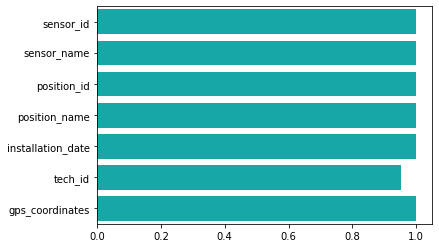

In [133]:
count_pdf = pdf_sensors_data.count() / pdf_sensors_data.shape[0]
sns.barplot(x=count_pdf, y=count_pdf.index, color='c')
print(count_pdf)

sensor_name          1.000000
count                1.000000
count_time           1.000000
count_month_year     1.000000
sensor_id            1.000000
position_id          1.000000
position_name        1.000000
installation_date    1.000000
tech_id              0.943404
gps_coordinates      1.000000
dtype: float64


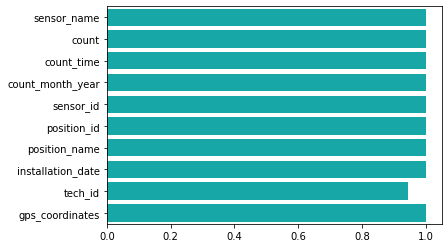

In [16]:
count_pdf = pdf_sensors.count() / pdf_sensors.shape[0]
sns.barplot(x=count_pdf, y=count_pdf.index, color='c')
print(count_pdf)

# Data exploration

### Basic exploration

In [52]:
profile = ProfileReport(pdf_sensors.astype({'position_id': str}))

In [53]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
pdf_sensors['count_time'].min()

Timestamp('2021-07-01 03:00:00')

In [30]:
pdf_sensors['count_time'].max()

Timestamp('2022-08-03 23:00:00')

In [49]:
pdf_sensors['count'].describe()

count    1.059651e+06
mean     6.844250e+01
std      9.236798e+01
min      0.000000e+00
25%      7.000000e+00
50%      3.600000e+01
75%      9.300000e+01
max      1.302000e+03
Name: count, dtype: float64

In [102]:
pdf_sensors[['sensor_id', 'sensor_name', 'position_id', 'tech_id']].astype({'position_id': str}).describe()

sensor_id                  sensor_name position_id  \
count                733785                      1018756     1018756   
unique                   98                          141          71   
top     100042374-110042374  Voie Georges Pompidou SO-NE         nan   
freq                   9573                         9573      284971   

            tech_id  
count        707348  
unique           68  
top     Y2H21025335  
freq          19146

### Month aggregation 

Text(0.5, 1.0, 'Average number of bike detected by sensor')

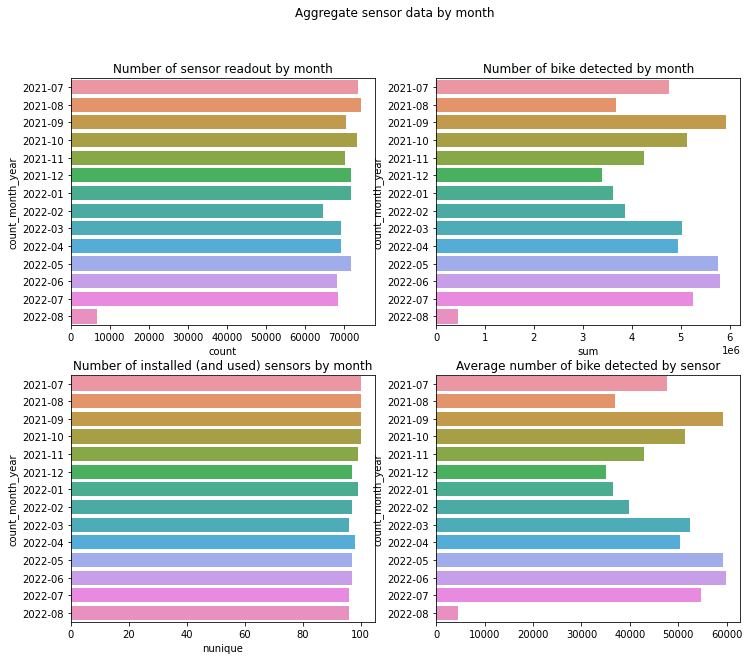

In [49]:
count_month = (pdf_sensors.groupby('count_month_year')
               .aggregate({'sensor_id': ['count', 'nunique'], 'count': ['sum']})
               .reset_index()
               .sort_values('count_month_year', ascending=True))

index = count_month['count_month_year']

fig = plt.figure(figsize=(12,10))
fig.suptitle('Aggregate sensor data by month')

ax = plt.subplot(2, 2, 1)
sns.barplot(ax=ax, x=count_month['sensor_id']['count'], y=index)
ax.set_title('Number of sensor readout by month')

ax = plt.subplot(2, 2, 2)
sns.barplot(ax=ax, x=count_month['count']['sum'], y=index)
ax.set_title('Number of bike detected by month')

ax = plt.subplot(2, 2, 3)
sns.barplot(ax=ax, x=count_month['sensor_id']['nunique'], y=index)
ax.set_title('Number of installed (and used) sensors by month')

ax = plt.subplot(2, 2, 4)
sns.barplot(ax=ax, x=count_month['count']['sum'] / count_month['sensor_id']['nunique'], y=index)
ax.set_title('Average number of bike detected by sensor')

### Day aggregation

In [54]:
holidays_rename_cols = {'Description': 'description',
                        'Date de début': 'start_date',
                        'Date de fin': 'end_date'}

In [55]:
pdf_holidays = pd.read_csv(os.path.join(data_directory, 'fr-en-calendrier-scolaire.csv'),
                           sep=';',
                           usecols=holidays_rename_cols.keys())
pdf_holidays = pdf_holidays.rename(columns=holidays_rename_cols)
pdf_holidays['start_date'] = pdf_holidays['start_date'].map(lambda x: pd.to_datetime(x[:-6])).dt.date
pdf_holidays['end_date'] = pdf_holidays['end_date'].map(lambda x: pd.to_datetime(x[:-6])).dt.date 
pdf_holidays = pdf_holidays[pdf_holidays['start_date'] < pd.to_datetime('2022-08-07').date()]

In [56]:
pdf_holidays.sort_values('start_date', ascending=True)

description  start_date    end_date
10            Vacances d'Été  2021-07-06  2021-09-02
0   Vacances de la Toussaint  2021-10-23  2021-11-08
5           Vacances de Noël  2021-12-18  2022-01-03
1           Vacances d'Hiver  2022-02-19  2022-03-07
6      Vacances de Printemps  2022-04-23  2022-05-09
12       Pont de l'Ascension  2022-05-26  2022-05-28
7             Vacances d'Été  2022-07-07  2022-09-01

In [83]:
pdf_off_days = pd.read_csv(os.path.join(data_directory, 'jours_feries_metropole.csv'),
                           usecols=['date', 'nom_jour_ferie'])
pdf_off_days = pdf_off_days[(pdf_off_days['date'] > '2021-07-01') & (pdf_off_days['date'] < '2022-08-08')]
pdf_off_days['date'] = pdf_off_days['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

In [91]:
pdf_day_agg = pdf_sensors.groupby('count_date')['count'].sum().reset_index()

In [92]:
pdf_day_agg['rolling_average'] = pdf_day_agg['count'].rolling(7).mean()

In [93]:
pdf_day_agg = pdf_day_agg.merge(pdf_off_days[['date']],
                                  left_on='count_date',
                                  right_on='date',
                                  how='left')
pdf_day_agg['ferie'] = pdf_day_agg['date'].notnull()
pdf_day_agg['ferie'] = pdf_day_agg['ferie'].fillna(False)
pdf_day_agg = pdf_day_agg.drop(columns=['date'])

In [96]:
pdf_day_agg

count_date     count  rolling_average  ferie
0    2021-07-01  210520.0              NaN  False
1    2021-07-02  199712.0              NaN  False
2    2021-07-03  151182.0              NaN  False
3    2021-07-04  101068.0              NaN  False
4    2021-07-05  162049.0              NaN  False
..          ...       ...              ...    ...
394  2022-07-30  132256.0    165970.571429  False
395  2022-07-31  117587.0    165220.285714  False
396  2022-08-01  142839.0    160976.428571  False
397  2022-08-02  156239.0    155848.142857  False
398  2022-08-03  143361.0    148886.857143  False

[399 rows x 4 columns]

(18809.0, 19211.0)

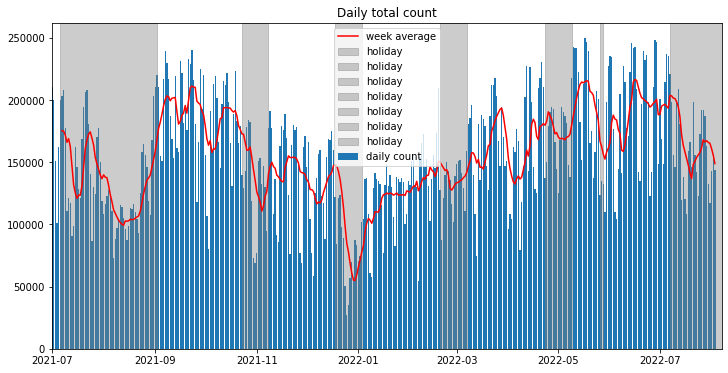

In [98]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(pdf_day_agg['count_date'], pdf_day_agg['count'], label='daily count')
ax.plot(pdf_day_agg['count_date'], pdf_day_agg['rolling_average'], 'r', label='week average')
for _, row in pdf_holidays.iterrows():
    ax.axvspan(row['start_date'], row['end_date'], alpha=0.4, color='grey')
ax.legend()
ax.set_title('Daily total count')
ax.set_xlim(datetime.strptime('2021-07-01', '%Y-%m-%d'),
            datetime.strptime('2022-08-07', '%Y-%m-%d'))

In [97]:
pdf_day_agg.groupby('ferie')['count'].mean()

ferie
False    156585.5323
True     103875.5000
Name: count, dtype: float64

In [69]:
pdf_weekday_agg = pdf_day_agg.copy()
pdf_weekday_agg['count_weekday'] = pdf_weekday_agg['count_date'].progress_map(lambda x: x.weekday())
pdf_weekday_agg = pdf_weekday_agg.groupby('count_weekday')[['count']].mean().reset_index()

100%|█████████████████████████████████████████████| 399/399 [00:00<00:00, 109252.34it/s]


In [70]:
weekday = {0: 'Lundi',
           1: 'Mardi',
           2: 'Mercredi',
           3: 'Jeudi', 
           4: 'Vendredi',
           5: 'Samedi',
           6: 'Dimanche'} 
pdf_weekday_agg['count_weekday'] = pdf_weekday_agg['count_weekday'].map(weekday)

<BarContainer object of 7 artists>

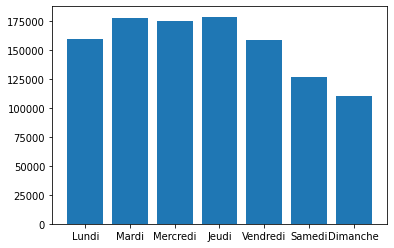

In [71]:
plt.bar(pdf_weekday_agg['count_weekday'], pdf_weekday_agg['count'])

In [60]:
os.listdir(data_directory)

['donnees-synop-essentielles-omm.csv',
 'comptage-velo-donnees-compteurs.csv',
 '.DS_Store',
 'jours_feries_metropole.csv',
 'velo-compteurs.csv',
 'fr-en-calendrier-scolaire.csv']

In [72]:
pdf_meteo = pd.read_csv('donnees-synop-essentielles-omm.csv')

In [73]:
pdf_off_days

date      nom_jour_ferie
215  2021-07-14          14 juillet
216  2021-08-15          Assomption
217  2021-11-01           Toussaint
218  2021-11-11         11 novembre
219  2021-12-25        Jour de Noël
220  2022-01-01         1er janvier
221  2022-04-18     Lundi de Pâques
222  2022-05-01             1er mai
223  2022-05-08               8 mai
224  2022-05-26           Ascension
225  2022-06-06  Lundi de Pentecôte
226  2022-07-14          14 juillet

### Time aggregation 

In [219]:
pdf_sensors['count_hour'] = pdf_sensors['count_time'].dt.hour

In [225]:
ps_hour_agg = pdf_sensors.groupby('count_hour')['count'].mean().sort_index()

Text(0.5, 1.0, 'Mean number of bike per hour')

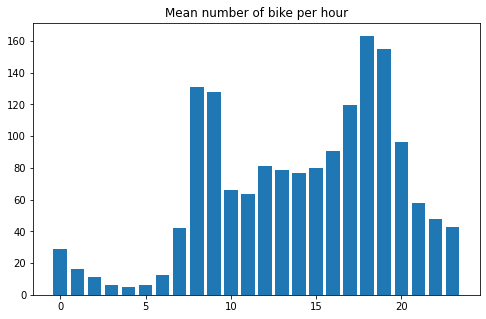

In [226]:
_, ax = plt.subplots(figsize=(8,5))
ax.bar(ps_hour_agg.index, ps_hour_agg)
ax.set_title('Mean number of bike per hour')

### Map representation

In [13]:
pdf_average_sensors = (pdf_sensors.groupby(['sensor_id', 'count_date'])
                       .aggregate({'count': 'sum', 'gps_coordinates': 'first', 'sensor_name': 'first'})
                       .groupby(['sensor_id'])
                       .aggregate({'count': 'mean', 'gps_coordinates': 'first', 'sensor_name': 'first'})
                       .reset_index())

In [18]:
pdf_average_sensors['count'].describe()

count     101.000000
mean     1574.284592
std      1114.049528
min         5.000000
25%       884.025063
50%      1378.437659
75%      1996.972222
max      6248.849624
Name: count, dtype: float64

(array([15., 33., 22., 18.,  3.,  5.,  2.,  2.,  0.,  1.]),
 array([5.00000000e+00, 6.29384962e+02, 1.25376992e+03, 1.87815489e+03,
        2.50253985e+03, 3.12692481e+03, 3.75130977e+03, 4.37569474e+03,
        5.00007970e+03, 5.62446466e+03, 6.24884962e+03]),
 <BarContainer object of 10 artists>)

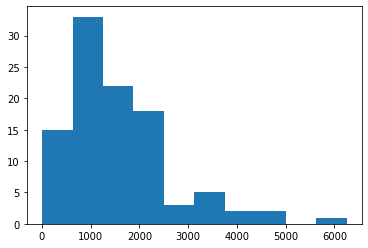

In [19]:
plt.hist(pdf_average_sensors['count'])

In [14]:
strats = [1_500, 3_000]

In [15]:
from ipywidgets import HTML
from ipyleaflet import Map, CircleMarker, LegendControl

center = (48.856614, 2.3522219)

m = Map(center=center, zoom=12)

for _, row in pdf_average_sensors.iterrows():
    circle_marker = CircleMarker(title=row['sensor_name'])
    circle_marker.location = row['gps_coordinates']
    circle_marker.radius = int(row['count']/200)
    if row['count'] > strats[0]:
        if row['count'] > strats[1]:
            circle_marker.color = 'red'
        else: 
            circle_marker.color = 'orange'
    else: 
        circle_marker.color = 'green'
    message = HTML()
    message.value = f'''sensor position : {row["sensor_name"]}<br>
                        daily count : {row["count"]}'''

    
    circle_marker.popup = message
    
    m.add_layer(circle_marker);
    
legend = LegendControl({"< 1500": 'green',
                        "> 1500": 'orange',
                        "> 3000": 'red'},
                       position="topright",
                       name="Nombre de passage par jour")
m.add_control(legend)

display(m)

Map(center=[48.856614, 2.3522219], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

### Cardinal distribution 

In [107]:
import re

In [81]:
pdf_extract_dir = pdf_sensors['sensor_name'].str.extract(pat='([N|S|E|O]{1,2})-([N|S|E|O]{1,2})')
pdf_extract_dir.columns = ['start_dir', 'dest_dir']
pdf_sensors = pd.concat([pdf_sensors, pdf_extract_dir], axis=1)

In [83]:
pdf_sensors[['sensor_name', 'start_dir', 'dest_dir']]

sensor_name start_dir dest_dir
0       97 avenue Denfert Rochereau SO-NE        SO       NE
1       97 avenue Denfert Rochereau SO-NE        SO       NE
2       97 avenue Denfert Rochereau SO-NE        SO       NE
3       97 avenue Denfert Rochereau SO-NE        SO       NE
4       97 avenue Denfert Rochereau SO-NE        SO       NE
...                                   ...       ...      ...
925108            69 Boulevard Ornano N-S         N        S
925109            69 Boulevard Ornano N-S         N        S
925110            69 Boulevard Ornano N-S         N        S
925111            69 Boulevard Ornano N-S         N        S
925112            69 Boulevard Ornano N-S         N        S

[925113 rows x 3 columns]

In [84]:
ps_group_card = pdf_sensors.groupby('dest_dir')['count'].sum()

<BarContainer object of 8 artists>

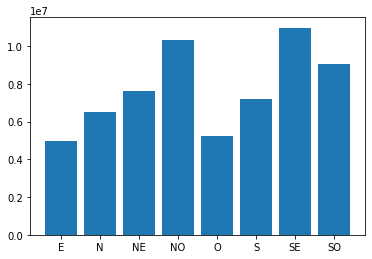

In [85]:
plt.bar(ps_group_card.index, ps_group_card.values)

In [86]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import numpy as np


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


Text(0.5, 1.0, 'direction distribution for bike travel')

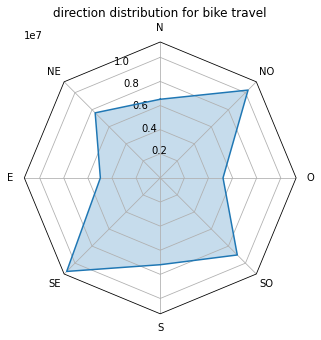

In [87]:
card_points = ['N', 'NE', 'E', 'SE', 'S', 'SO', 'O', 'NO']

theta = radar_factory(len(card_points), frame='polygon')

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
ax.plot(theta, ps_group_card.loc[card_points])
ax.fill(theta, ps_group_card.loc[card_points], alpha=0.25)
ax.set_varlabels(card_points)
ax.set_title('direction distribution for bike travel')

In [198]:
pdf_nb_sensors = pdf_sensors.groupby('dest_dir')['sensor_id'].nunique()

Text(0.5, 1.0, 'direction distribution for bike travel')

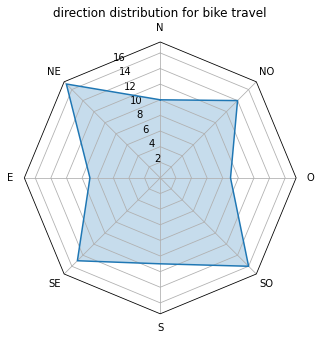

In [199]:
card_points = ['N', 'NE', 'E', 'SE', 'S', 'SO', 'O', 'NO']

theta = radar_factory(len(card_points), frame='polygon')

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
ax.plot(theta, pdf_nb_sensors.loc[card_points])
ax.fill(theta, pdf_nb_sensors.loc[card_points], alpha=0.25)
ax.set_varlabels(card_points)
ax.set_title('direction distribution for bike travel')

In [90]:
pdf_sensors['count_hour'] = pdf_sensors['count_time'].dt.hour

ps_sensors_hour = pdf_sensors.groupby(['count_hour', 'dest_dir'])['count'].mean()

In [88]:
pdf_sensors['count_hour'] = pdf_sensors['count_time'].dt.hour

ps_sensors_hour = pdf_sensors.groupby(['count_hour', 'dest_dir'])['count'].sum()

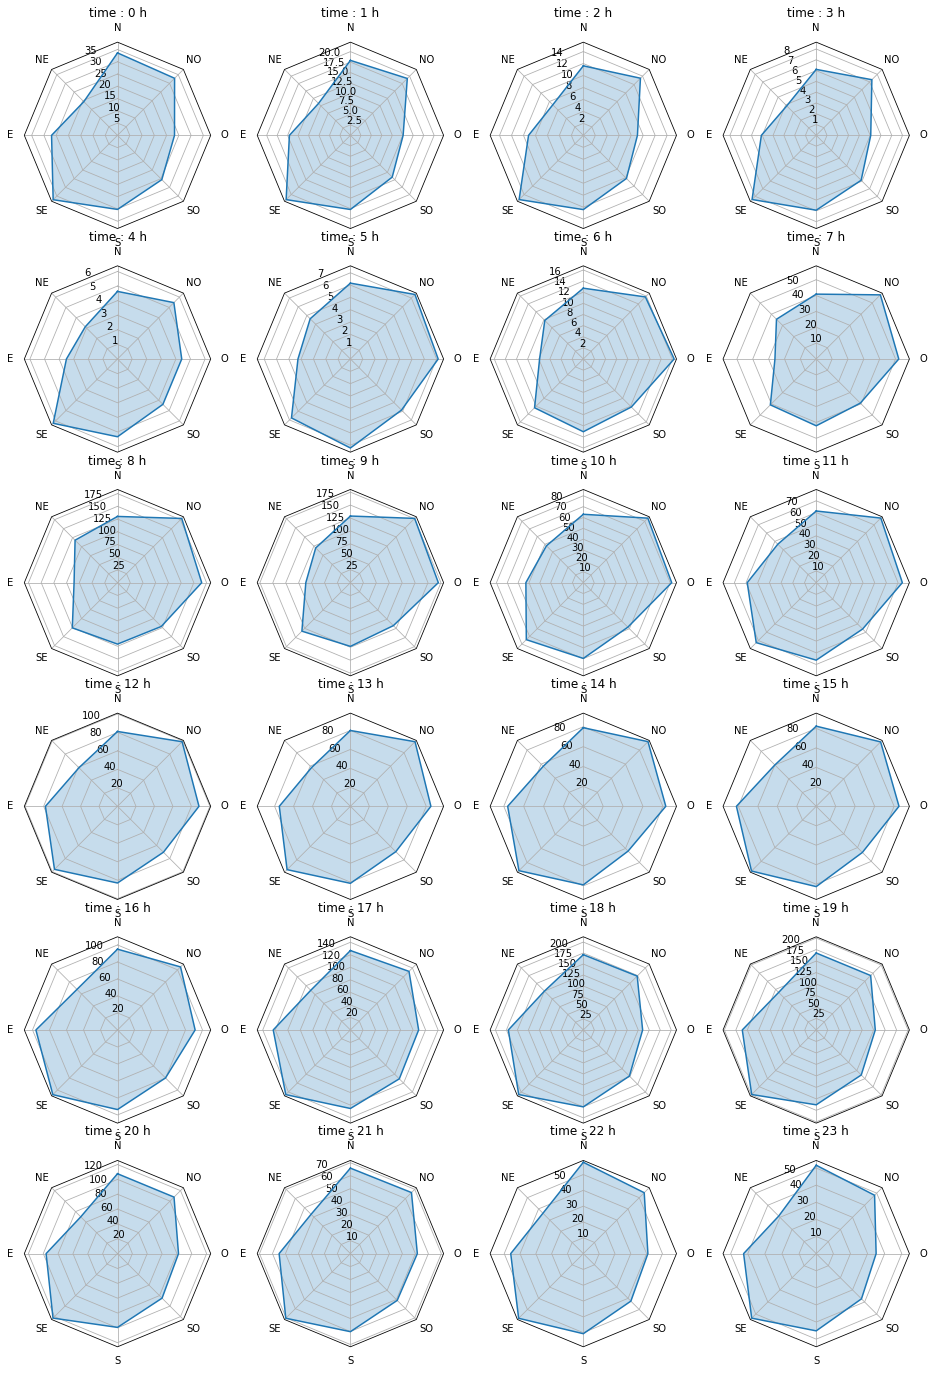

In [91]:
card_points = ['N', 'NE', 'E', 'SE', 'S', 'SO', 'O', 'NO']

theta = radar_factory(len(card_points), frame='polygon')

fig, axs = plt.subplots(6, 4, figsize=(16, 24), subplot_kw=dict(projection='radar'))

for hour, ax in zip(range(24), axs.flat):
    ax.plot(theta, ps_sensors_hour.loc[(hour, card_points)])
    ax.fill(theta, ps_sensors_hour.loc[(hour, card_points)], alpha=0.25)
    #ax.set_ylim((0, ps_sensors_hour.max()))
    ax.set_varlabels(card_points)
    ax.set_title(f'time : {hour} h')

Text(0.5, 1.0, 'Mean number of bike per hour')

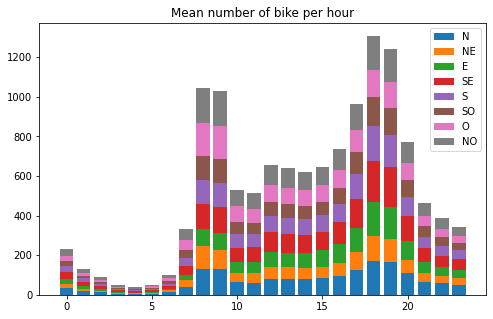

In [33]:
card_points = ['N', 'NE', 'E', 'SE', 'S', 'SO', 'O', 'NO']

_, ax = plt.subplots(figsize=(8,5))

previous_height = np.zeros(24)
for direction in card_points:
    height = ps_sensors_hour.swaplevel().loc[direction]
    ax.bar(range(24),
           height,
           bottom=previous_height,
           label=direction)
    
    previous_height += height
    
ax.legend()
ax.set_title('Mean number of bike per hour')

Cardinal plots mostly show that most of the traffic is concentrated on NE-SO trajectory, most likely linked to the orientation of big Paris roads and also reflet population distribution between neighbors.
But a majority of sensors are orientated on the NO-SE axis. 

### correlation between sensors

In [73]:
pdf_sensors_time = pd.pivot_table(pdf_sensors,
                                   values='count',
                                   index=['count_time'],
                                   columns=['sensor_id', 'sensor_name'])

corr = pdf_sensors_time.fillna(0).corr()

In [95]:
pdf_corr = corr.stack().stack()
pdf_corr.index.names=['sensor_id', 'sensor_name','sensor_name_2', 'sensor_id_2']
pdf_corr = pdf_corr.reset_index().rename(columns={0: 'correlation'})
pdf_corr = pdf_corr[pdf_corr['sensor_id'] != pdf_corr['sensor_id_2']]
pdf_corr = pdf_corr[pdf_corr['sensor_name'] != pdf_corr['sensor_name_2']]
pdf_corr['couple_ids'] = pdf_corr[['sensor_id', 'sensor_id_2']].apply(
    lambda x: frozenset(x), axis=1)
pdf_corr = pdf_corr.drop_duplicates(subset=['couple_ids'])

In [100]:
pd.set_option('display.max_rows', 200)
pdf_corr.sort_values('correlation', ascending=False).iloc[:10]

sensor_id                      sensor_name  \
1911  100047533-101047533    89 boulevard de Magenta NO-SE   
3057  100047544-101047544  77 boulevard Richard Lenoir N-S   
2215  100047536-101047536   102 boulevard de Magenta SE-NO   
2619  100047540-101047540  72 boulevard Richard Lenoir S-N   
1811  100044506-101044506      72 boulevard Voltaire NO-SE   
1467  100044493-101044493      67 boulevard Voltaire SE-NO   
1767  100044506-101044506      72 boulevard Voltaire NO-SE   
1452  100044493-101044493      67 boulevard Voltaire SE-NO   
2106  100047535-101047535         Pont du Garigliano NO-SE   
7165  100056330-103056330        36 quai de Grenelle SO-NE   

                             sensor_name_2          sensor_id_2  correlation  \
1911  Totem 73 boulevard de Sébastopol N-S  100057445-103057445     0.980052   
3057         27 quai de la Tournelle SE-NO  100056336-105056336     0.977383   
2215  Totem 73 boulevard de Sébastopol S-N  100057445-104057445     0.974763   
2619  Totem 73 boulevard de Sébastopol S-N  100057445-104057445     0.971550   
1811  Totem 73 boulevard de Sébastopol S-N  100057445-104057445     0.971149   
1467       77 boulevard Richard Lenoir N-S  100047544-101047544     0.971008   
1767       72 boulevard Richard Lenoir S-N  100047540-101047540     0.966936   
1452                  38 rue Turbigo NE-SO  100056334-103056334     0.966204   
2106              Pont du Garigliano SE-NO  100047551-102047551     0.964328   
7165      Totem 85 quai d'Austerlitz NO-SE  100057329-104057329     0.963927   

                                      couple_ids  
1911  (100047533-101047533, 100057445-103057445)  
3057  (100047544-101047544, 100056336-105056336)  
2215  (100057445-104057445, 100047536-101047536)  
2619  (100057445-104057445, 100047540-101047540)  
1811  (100044506-101044506, 100057445-104057445)  
1467  (100044493-101044493, 100047544-101047544)  
1767  (100044506-101044506, 100047540-101047540)  
1452  (100044493-101044493, 100056334-103056334)  
2106  (100047535-101047535, 100047551-102047551)  
7165  (100056330-103056330, 100057329-104057329)

In [101]:
pd.set_option('display.max_rows', 200)
pdf_corr.sort_values('correlation', ascending=True).iloc[:10]

sensor_id                         sensor_name  \
9526  100063175-353277233           20 Avenue de Clichy NO-SE   
9006  100060175-101060175            30 rue Saint Jacques N-S   
4057  100047550-101047550  35 boulevard de Ménilmontant NO-SE   
9529  100063175-353277233           20 Avenue de Clichy NO-SE   
9007  100060175-101060175            30 rue Saint Jacques N-S   
9627  100063175-353277235           20 Avenue de Clichy SE-NO   
630   100007049-102007049            28 boulevard Diderot E-O   
9541  100063175-353277233           20 Avenue de Clichy NO-SE   
9410  100063174-101063174             69 Boulevard Ornano N-S   
9411  100063174-101063174             69 Boulevard Ornano N-S   

                           sensor_name_2          sensor_id_2  correlation  \
9526            30 rue Saint Jacques N-S  300021312-353293580    -0.318255   
9006           20 Avenue de Clichy NO-SE  100063175-353277233    -0.318255   
4057           20 Avenue de Clichy NO-SE  100063175-353277233    -0.316875   
9529  35 boulevard de Ménilmontant NO-SE  100065336-104065336    -0.316875   
9007           20 Avenue de Clichy SE-NO  100063175-353277235    -0.313374   
9627            30 rue Saint Jacques N-S  300021312-353293580    -0.313374   
630   26 boulevard de Ménilmontant SE-NO  100047537-101047537    -0.285694   
9541             69 Boulevard Ornano N-S  300021320-353293614    -0.282202   
9410           20 Avenue de Clichy NO-SE  100063175-353277233    -0.282202   
9411           20 Avenue de Clichy SE-NO  100063175-353277235    -0.277154   

                                      couple_ids  
9526  (300021312-353293580, 100063175-353277233)  
9006  (100060175-101060175, 100063175-353277233)  
4057  (100047550-101047550, 100063175-353277233)  
9529  (100065336-104065336, 100063175-353277233)  
9007  (100060175-101060175, 100063175-353277235)  
9627  (300021312-353293580, 100063175-353277235)  
630   (100007049-102007049, 100047537-101047537)  
9541  (300021320-353293614, 100063175-353277233)  
9410  (100063174-101063174, 100063175-353277233)  
9411  (100063174-101063174, 100063175-353277235)

(array([  19.,   35.,  194.,   72.,  310.,  537.,  835.,  868., 1185.,
         992.]),
 array([-0.31825468, -0.18842398, -0.05859327,  0.07123743,  0.20106813,
         0.33089883,  0.46072954,  0.59056024,  0.72039094,  0.85022164,
         0.98005235]),
 <BarContainer object of 10 artists>)

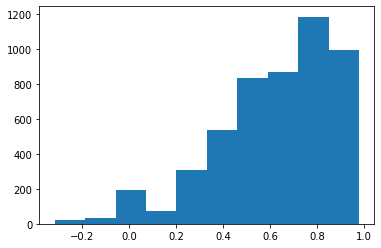

In [103]:
plt.hist(pdf_corr['correlation'])

In [104]:
corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format('{:.2f}')


<AxesSubplot:xlabel='sensor_id', ylabel='sensor_id'>

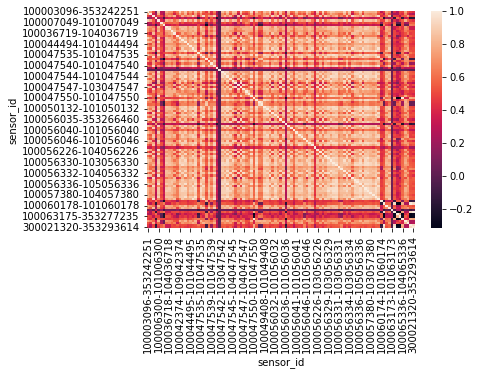

In [208]:
sns.heatmap(corr)

In [34]:
from geopy.distance import distance

In [41]:
pdf_compare_sensors = pdf_sensors_data[['sensor_id', 'gps_coordinates']].merge(
    pdf_sensors_data[['sensor_id', 'gps_coordinates']],
    how='cross',
    suffixes=('', '_2'))

In [43]:
pdf_compare_sensors['distance'] = pdf_compare_sensors[['gps_coordinates', 'gps_coordinates_2']].apply(
    lambda row: distance(row['gps_coordinates'], row['gps_coordinates_2']).m, axis=1)

In [53]:
pdf_sensors_time = pd.pivot_table(pdf_sensors,
                                   values='count',
                                   index=['count_time'],
                                   columns=['sensor_id'])

corr = pdf_sensors_time.fillna(0).corr()

In [67]:
pdf_corr = corr.stack()
pdf_corr.index.names=['sensor_id', 'sensor_id_2']
pdf_corr = pdf_corr.reset_index().rename(columns={0: 'correlation'})

In [70]:
pdf_compare_sensors = pdf_corr.merge(pdf_compare_sensors,
                                     on=['sensor_id', 'sensor_id_2'],
                                     how='left')

In [71]:
pdf_compare_sensors[['distance', 'correlation']].corr()

distance  correlation
distance     1.000000    -0.086185
correlation -0.086185     1.000000

### Environnement influence 

In [285]:
def get_elevation(coor):
    result = requests.get(f'https://wxs.ign.fr/calcul/alti/rest/elevation.json?lon={coor[1]}&lat={coor[0]}&zonly=true')
    
    return result.json()['elevations'][0]

In [286]:
pdf_sensors_data['elevation'] = pdf_sensors_data['gps_coordinates'].progress_map(get_elevation)

100%|█████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.86it/s]


In [295]:
pd.set_option('display.max_rows', 200)

In [298]:
pdf_sensors_data.loc[101]

sensor_id              300026304-353326012
sensor_name          Y2H18086318 [Bike IN]
position_id                      300026304
position_name                  Y2H18086318
installation_date               2022-08-02
tech_id                        Y2H18086318
gps_coordinates                 [0.0, 0.0]
elevation                         -99999.0
Name: 101, dtype: object

In [301]:
pdf_sensors = pdf_sensors.merge(pdf_sensors_data[['sensor_id', 'elevation']],
                                on='sensor_id', 
                                how='left')

In [302]:
pdf_group_sensors_elevation = (pdf_sensors.groupby(['sensor_id', 'elevation'])['count'].sum()
                     .reset_index())

<AxesSubplot:xlabel='elevation', ylabel='count'>

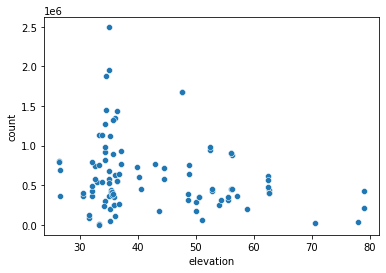

In [303]:
sns.scatterplot(data=pdf_group_sensors_elevation, x='elevation', y='count')

In [16]:
# historic temperature are not clean enough to be used 
meteo_rename_cols = {'Date': 'time',
                     'Température (°C)': 'temperature',
                     'Humidité': 'humidity',
                     'Précipitations dans les 24 dernières heures': 'rain_level'}
                     

In [17]:
pdf_meteo = pd.read_csv(os.path.join(data_directory, 'donnees-synop-essentielles-omm.csv'),
                        sep=';',
                        usecols=meteo_rename_cols.keys())

In [18]:
pdf_meteo = pdf_meteo.rename(columns=meteo_rename_cols)
pdf_meteo['time'] = pdf_meteo['time'].progress_map(
    lambda x: datetime.strptime(x[:-6], '%Y-%m-%dT%H:%M:%S'))
pdf_meteo['hour'] = pdf_meteo['time'].dt.hour
pdf_meteo['date'] = pdf_meteo['time'].dt.date

100%|██████████████████████████████████| 3213/3213 [00:00<00:00, 71208.22it/s]


In [19]:
pdf_meteo

time  humidity  rain_level  temperature  hour        date
0    2022-07-18 20:00:00        19         0.0         35.8    20  2022-07-18
1    2022-07-23 20:00:00        47        -0.1         26.9    20  2022-07-23
2    2022-07-20 02:00:00        62        -0.1         24.6     2  2022-07-20
3    2022-07-24 23:00:00        48         0.0         26.5    23  2022-07-24
4    2022-07-16 20:00:00        32         0.0         27.5    20  2022-07-16
...                  ...       ...         ...          ...   ...         ...
3208 2022-07-01 20:00:00        40         0.0         22.2    20  2022-07-01
3209 2022-07-21 02:00:00        97        10.0         17.7     2  2022-07-21
3210 2022-07-19 14:00:00        17         0.0         39.0    14  2022-07-19
3211 2022-07-10 05:00:00        74         0.0         14.9     5  2022-07-10
3212 2022-07-23 14:00:00        65         0.6         24.4    14  2022-07-23

[3213 rows x 6 columns]

In [20]:
pdf_meteo_day_temp = pdf_meteo.groupby('date').aggregate({'temperature': ['min', 'max']})['temperature']
pdf_meteo_day_temp = pdf_meteo_day_temp.rename(columns={'min': 'min_temp', 'max': 'max_temp'})

In [21]:
pdf_meteo_day_rain = pdf_meteo[pdf_meteo['hour']==23][['date', 'rain_level']].set_index('date')

In [22]:
pdf_meteo_day = pdf_meteo_day_temp.merge(pdf_meteo_day_rain, left_index=True, right_index=True)

In [23]:
pdf_meteo_day = pdf_meteo_day.fillna(0)

In [24]:
pdf_meteo_day

min_temp  max_temp  rain_level
date                                      
2021-07-01      14.1      22.2         0.0
2021-07-02      14.3      27.1         0.0
2021-07-03      17.5      23.6        -0.1
2021-07-04      16.2      21.2        14.4
2021-07-05      14.6      21.7         5.2
...              ...       ...         ...
2022-08-01      18.6      27.9         0.0
2022-08-02      18.6      31.3         0.0
2022-08-03      20.0      35.2         0.0
2022-08-04      20.7      29.4         1.8
2022-08-05      16.1      25.7         0.0

[254 rows x 3 columns]

(array([202.,  18.,   6.,   7.,   5.,   5.,   1.,   1.,   1.,   3.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([-0.1 ,  1.37,  2.84,  4.31,  5.78,  7.25,  8.72, 10.19, 11.66,
        13.13, 14.6 , 16.07, 17.54, 19.01, 20.48, 21.95, 23.42, 24.89,
        26.36, 27.83, 29.3 , 30.77, 32.24, 33.71, 35.18, 36.65, 38.12,
        39.59, 41.06, 42.53, 44.  ]),
 <BarContainer object of 30 artists>)

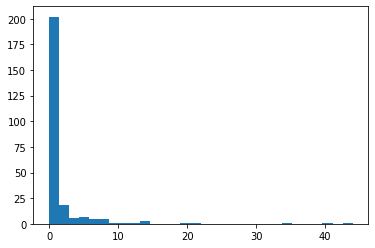

In [34]:
plt.hist(pdf_meteo_day['rain_level'], bins=30)

In [25]:
pdf_day_agg = pdf_sensors.groupby('count_date')['count'].sum().reset_index()
pdf_day_agg = pdf_day_agg.merge(pdf_meteo_day,
                                left_on='count_date',
                                right_index=True)

<AxesSubplot:xlabel='max_temp', ylabel='count'>

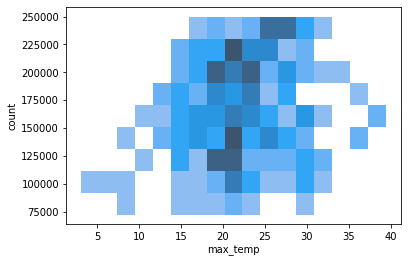

In [48]:
sns.histplot(data=pdf_day_agg, x='max_temp', y='count')

(0.0, 258589.5)

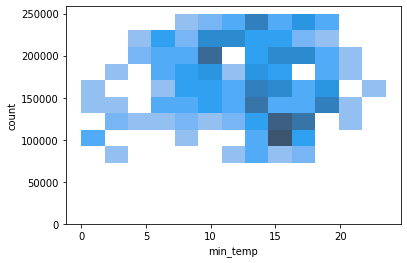

In [49]:
sns.histplot(data=pdf_day_agg, x='min_temp', y='count')
plt.ylim((0,None))

(0.0, 258589.5)

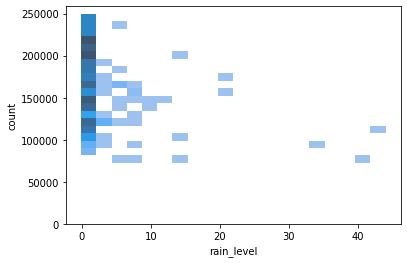

In [55]:
sns.histplot(data=pdf_day_agg, x='rain_level', y='count', bins=20)
plt.ylim((0,None))

In [26]:
pdf_day_agg[pdf_day_agg['rain_level'] < 0.2].shape[0]

159

In [31]:
import numpy as np

In [68]:
pdf_day_agg['rainy_day'] = pdf_day_agg['rain_level'] > 1

In [74]:
pdf_day_agg.groupby('rainy_day')['count'].mean()

rainy_day
False    174894.470000
True     143392.826923
Name: count, dtype: float64

In [79]:
 143392.826923 / 174894.470000

0.8198819946851378

In [75]:
pdf_day_agg['cold_day'] = pdf_day_agg['max_temp'] < 10

In [76]:
pdf_day_agg.groupby('cold_day')['count'].mean()

cold_day
False    169621.161943
True     107778.800000
Name: count, dtype: float64

In [80]:
107778.800000 / 169621.161943

0.635408924012785

* Relatively low correlation between environment variables 
* -20% traffic on a rainy day
* -35% traffic on a cold day
* Some correlation between sensor elevation and traffic